In [1]:
# KT Noted: Using CUBEMS environment
# KT Noted: ChatGPT o3-mini-high (7 Feb 2025)

In [2]:
import time
import pandas as pd
import numpy as np

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [4]:
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score

In [5]:
# Set a global random seed
np.random.seed(42)

In [6]:
# -------------------------------
# 1. Data Preparation & Splitting
# -------------------------------

In [7]:
# Load the CSV file
file_path = r"C:\Users\kornn\Dropbox\00_EnergyModel_Weather\Dataset\Training_Combinded\train_df.csv"  
train_df = pd.read_csv(file_path)
train_df.head()

,Date,Total_kWh,Hour_of_Day,Day_of_week,Holiday,Weekend,Weekday,Working_Hour,Noon,Temperature,Dew Point,Humidity,Pressure,Solar
0,2018-07-01 00:00:00,176.261667,0,6,0,1,0,0,0,25.0,24.2,95,1006.43,0
1,2018-07-01 01:00:00,177.300000,1,6,0,1,0,0,0,25.5,24.8,96,1006.43,0
2,2018-07-01 02:00:00,177.048833,2,6,0,1,0,0,0,25.8,24.9,95,1005.76,0
3,2018-07-01 03:00:00,175.129167,3,6,0,1,0,0,0,25.7,24.7,94,1005.08,0
4,2018-07-01 04:00:00,183.175000,4,6,0,1,0,0,0,26.3,24.6,90,1005.42,0


In [8]:
train_df['Date'] = pd.to_datetime(train_df['Date']) # Make Date column is in datetime format

In [9]:
# Train and Test Split 
train_set = (train_df['Date'] >= '2018-07-01 00:00:00') & (train_df['Date'] <= '2019-06-30 23:00:00')
test_set = (train_df['Date'] >= '2019-07-01 00:00:00') & (train_df['Date'] <= '2019-08-31 23:00:00')

In [10]:
# Create the training and test DataFrames
train_data = train_df.loc[train_set].copy()
test_data = train_df.loc[test_set].copy()

In [11]:
# -------------------------------
# 2. Set Features and Target
# -------------------------------

In [12]:
target_col = 'Total_kWh' # Set the target variable
feature_cols = [col for col in train_df.columns if col not in ['Date', target_col]] # Set the features

In [13]:
X_train = train_data[feature_cols]
y_train = train_data[target_col]
X_test = test_data[feature_cols]
y_test = test_data[target_col]

In [14]:
# -------------------------------
# 3. Model Training with LightGBM
# -------------------------------

In [15]:
# Fixed parameters for the LightGBM model
base_params = {
    'objective': 'regression',   # The loss function.
    'feature_fraction': 0.9,     # Fraction of features used per iteration.
    'bagging_fraction': 0.8,     # Fraction of training data used per iteration.
    'bagging_freq': 5,           # How often (in iterations) to perform bagging.
    'force_col_wise': True       # Ensures column-wise data storage, reducing memory overhead
}

In [16]:
model = LGBMRegressor(**base_params)

In [17]:
# Define hyperparameter search space
param_grid = {
    "learning_rate": [0.005, 0.01, 0.02],
    "num_leaves": [50, 70, 90],
    "max_depth": [10, 15, 20],
    "n_estimators": [500, 1000, 2000],
    "min_data_in_leaf": [20, 50, 100, 200],
    "min_gain_to_split": [0, 0.01, 0.1],
    "lambda_l1": [0, 0.1, 0.5, 1, 2],
    "lambda_l2": [0, 0.1, 0.5, 1, 2]
}

In [18]:
# Run Random Search
random_search = RandomizedSearchCV(
    estimator=model,                 # The model (LightGBM)
    param_distributions=param_grid,  # The dictionary of hyperparameters to test
    n_iter=100,                       # Number of random combinations to try
    cv=5,                            # n-fold cross-validation
    scoring="neg_root_mean_squared_error",  # Using negative MSE as the scoring metric
    verbose=1,                               # Prints progress of the search
    n_jobs=-1,                              # Use all available cores on the machine
    random_state=42    
)

In [19]:
# Start timing before training
start_time = time.time()

In [20]:
# Fit the grid search, including early stopping callbacks if desired
random_search.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='rmse',
    callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=True),
               lgb.log_evaluation(period=100)]
)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


c:\Users\kornn\anaconda3\envs\CUBEMS\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\kornn\anaconda3\envs\CUBEMS\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\kornn\anaconda3\envs\CUBEMS\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\kornn\anaconda3\envs\CUBEMS\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\kornn\anaconda3\envs\CUBEMS\lib\subprocess.py", line 1456, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(exec

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[L

RandomizedSearchCV(cv=5,
                   estimator=LGBMRegressor(bagging_fraction=0.8, bagging_freq=5,
                                           feature_fraction=0.9,
                                           force_col_wise=True,
                                           objective='regression'),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'lambda_l1': [0, 0.1, 0.5, 1, 2],
                                        'lambda_l2': [0, 0.1, 0.5, 1, 2],
                                        'learning_rate': [0.005, 0.01, 0.02],
                                        'max_depth': [10, 15, 20],
                                        'min_data_in_leaf': [20, 50, 100, 200],
                                        'min_gain_to_split': [0, 0.01, 0.1],
                                        'n_estimators': [500, 1000, 2000],
                                        'num_leaves': [50, 70, 90]},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=1)

In [21]:
# End timing after training
end_time = time.time()
training_time = end_time - start_time # Calculate training duration
print(f"Model training time: {training_time/60:.2f} minutes") 

Model training time: 9.13 minutes


In [22]:
# Best Model 
print("\nBest parameters found: ", random_search.best_params_)

# Retrieve the best estimator for further evaluation or prediction:
best_model_params = random_search.best_estimator_
best_model_params


Best parameters found:  {'num_leaves': 70, 'n_estimators': 1000, 'min_gain_to_split': 0.01, 'min_data_in_leaf': 20, 'max_depth': 15, 'learning_rate': 0.02, 'lambda_l2': 0, 'lambda_l1': 0}


LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, feature_fraction=0.9,
              force_col_wise=True, lambda_l1=0, lambda_l2=0, learning_rate=0.02,
              max_depth=15, min_data_in_leaf=20, min_gain_to_split=0.01,
              n_estimators=1000, num_leaves=70, objective='regression')

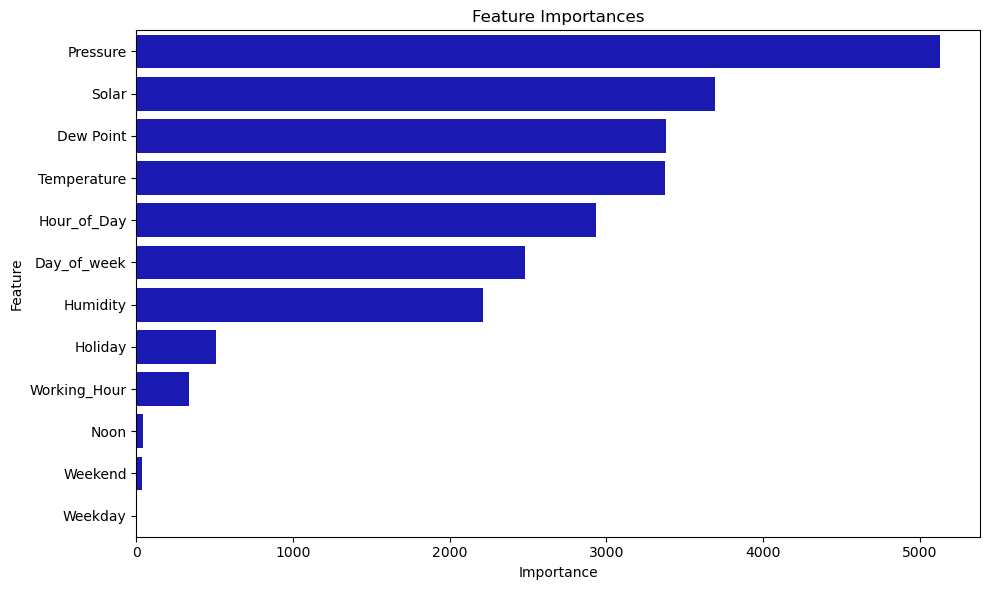

In [23]:
# Feature importance of the best model
importance = best_model_params.feature_importances_
feat_importance = pd.DataFrame({'feature': feature_cols, 'importance': importance})
feat_importance = feat_importance.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=feat_importance, color = 'mediumblue') #palette="YlGnBu_r","YlGn_r","winter"
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

C:\Users\kornn\AppData\Local\Temp\ipykernel_16436\1824951292.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


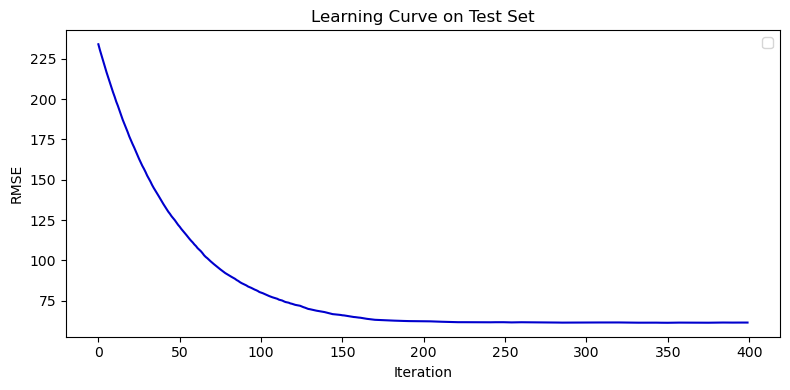

In [24]:
# Learning Curve: view how RMSE evolved during training, you can plot the learning curve.
# Note: The sklearn API stores evaluation results in model.evals_result_ if early stopping is used.
if hasattr(best_model_params, 'evals_result_'):
    results = best_model_params.evals_result_
    # 'validation_0' corresponds to the first (and only) eval_set provided, here our test set.
    rmse_vals = results['valid_0']['rmse']
    plt.figure(figsize=(8, 4))
    plt.plot(rmse_vals, color='mediumblue')
    plt.xlabel('Iteration')
    plt.ylabel('RMSE')
    plt.title('Learning Curve on Test Set')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [25]:
# -------------------------------
# 4. Result on Train set 
# -------------------------------

In [26]:
# Calculate evaluation metrics: RMSE, CV(RMSE), NMBE, and R2
def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    cv_rmse = (rmse / np.mean(y_true)) * 100
    nmbe = (np.mean(y_pred - y_true) / np.mean(y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    return {'rmse': rmse, 'cv_rmse': cv_rmse, 'nmbe': nmbe, 'r2': r2}

In [27]:
# Predict on the training set using the best_model 
y_pred_train = best_model_params.predict(X_train) 
train_metrics = evaluate_model(y_train, y_pred_train)

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


In [28]:
print("Evaluation Metrics on Train Set (Random Search):")
print("RMSE: {:.3f}".format(train_metrics['rmse']))
print("CV(RMSE): {:.2f}%".format(train_metrics['cv_rmse']), "| IPMVP < 20% | ASHRAE & FEMP < 30%")
print("NMBE: {:.2f}%".format(train_metrics['nmbe']), "| IPMVP < 5% | ASHRAE & FEMP < 10%")
print("R2 Score: {:.3f}".format(train_metrics['r2']), "| IPMVP & ASHRAE > 0.75 | FEMP = NA")

Evaluation Metrics on Train Set (Random Search):
RMSE: 40.182
CV(RMSE): 15.51% | IPMVP < 20% | ASHRAE & FEMP < 30%
NMBE: 0.00% | IPMVP < 5% | ASHRAE & FEMP < 10%
R2 Score: 0.959 | IPMVP & ASHRAE > 0.75 | FEMP = NA


In [29]:
# -------------------------------
# 5. Model Evaluation on Test set
# -------------------------------

In [30]:
# Predict on the test set using the best_model 
y_pred_test = best_model_params.predict(X_test)  
test_metrics = evaluate_model(y_test, y_pred_test)

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


In [31]:
print("Evaluation Metrics on Test Set (Random Search):")
print("RMSE: {:.3f}".format(test_metrics['rmse']))
print("CV(RMSE): {:.2f}%".format(test_metrics['cv_rmse']), "| IPMVP < 20% | ASHRAE & FEMP < 30%")
print("NMBE: {:.2f}%".format(test_metrics['nmbe']), "| IPMVP < 5% | ASHRAE & FEMP < 10%")
print("R2 Score: {:.3f}".format(test_metrics['r2']), "| IPMVP & ASHRAE > 0.75 | FEMP = NA")

Evaluation Metrics on Test Set (Random Search):
RMSE: 61.333
CV(RMSE): 21.41% | IPMVP < 20% | ASHRAE & FEMP < 30%
NMBE: -1.38% | IPMVP < 5% | ASHRAE & FEMP < 10%
R2 Score: 0.932 | IPMVP & ASHRAE > 0.75 | FEMP = NA


In [32]:
# -------------------------------
# 5. Plots
# -------------------------------

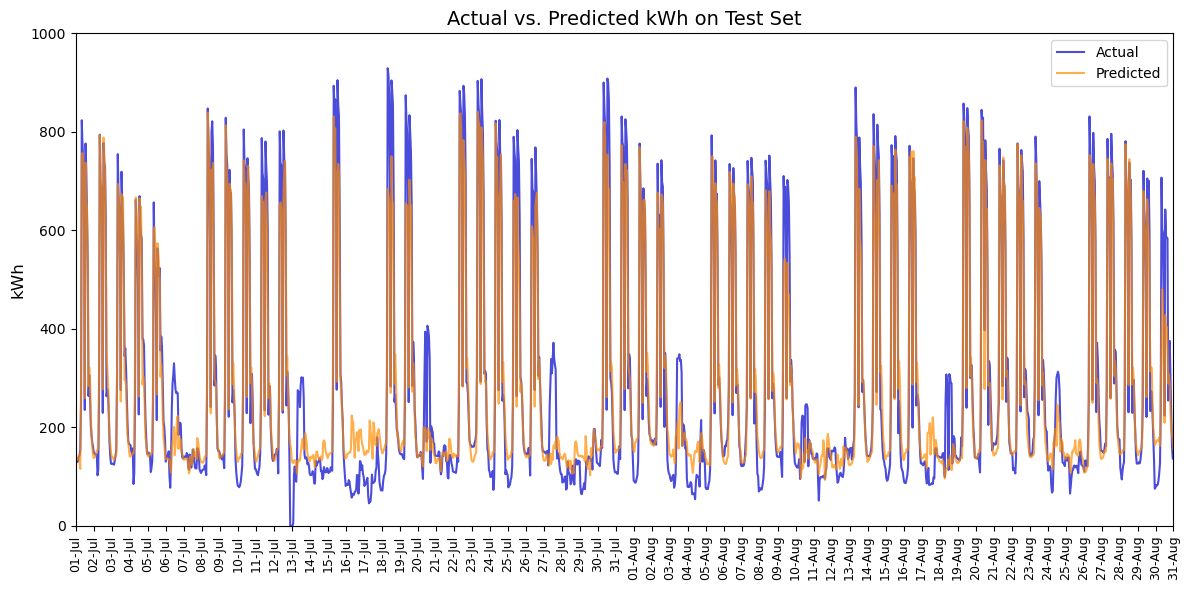

In [33]:
# (a) Actual vs. Predicted over time
plt.figure(figsize=(12,6))
plt.plot(test_data['Date'], y_test, label='Actual', linestyle='-', color='mediumblue', alpha=0.7)
plt.plot(test_data['Date'], y_pred_test, label='Predicted', linestyle='-', color='darkorange', alpha=0.7)
plt.xlabel('')
plt.ylabel('kWh', fontsize=12)
plt.ylim(0, 1000)
plt.title('Actual vs. Predicted kWh on Test Set', fontsize=14)
plt.legend()

month_ticks = pd.date_range(start='2019-07-01', end='2019-08-31', freq='D')
plt.xticks(month_ticks, month_ticks.strftime('%d-%b'), rotation=90, fontsize=9)

plt.xlim(pd.Timestamp('2019-07-01'), pd.Timestamp('2019-08-31'))

plt.tight_layout()
plt.show()

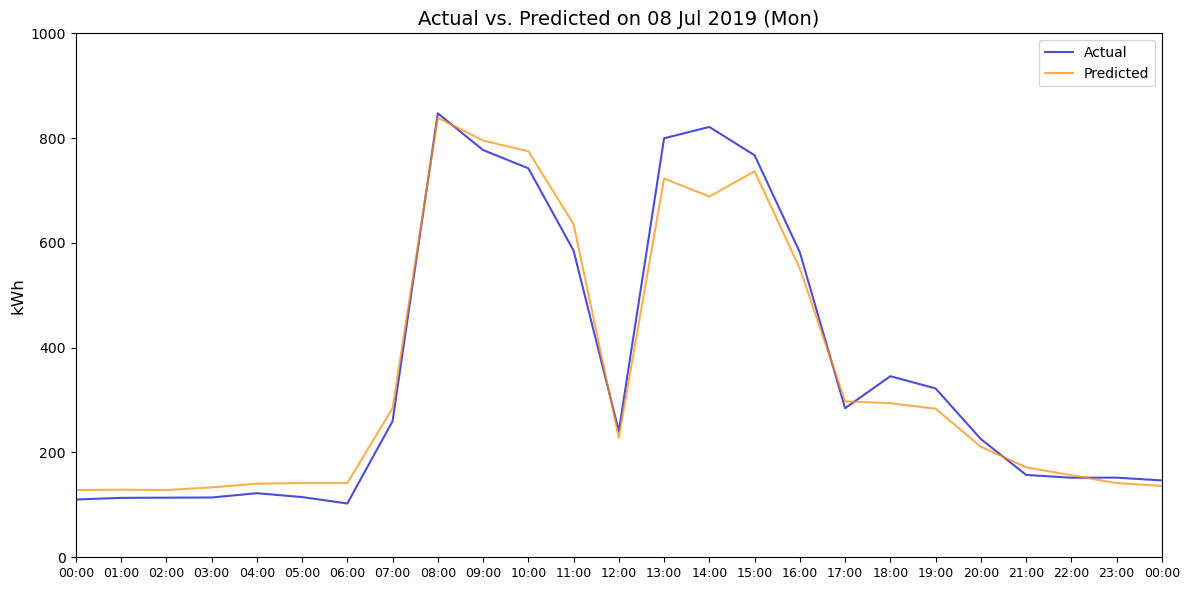

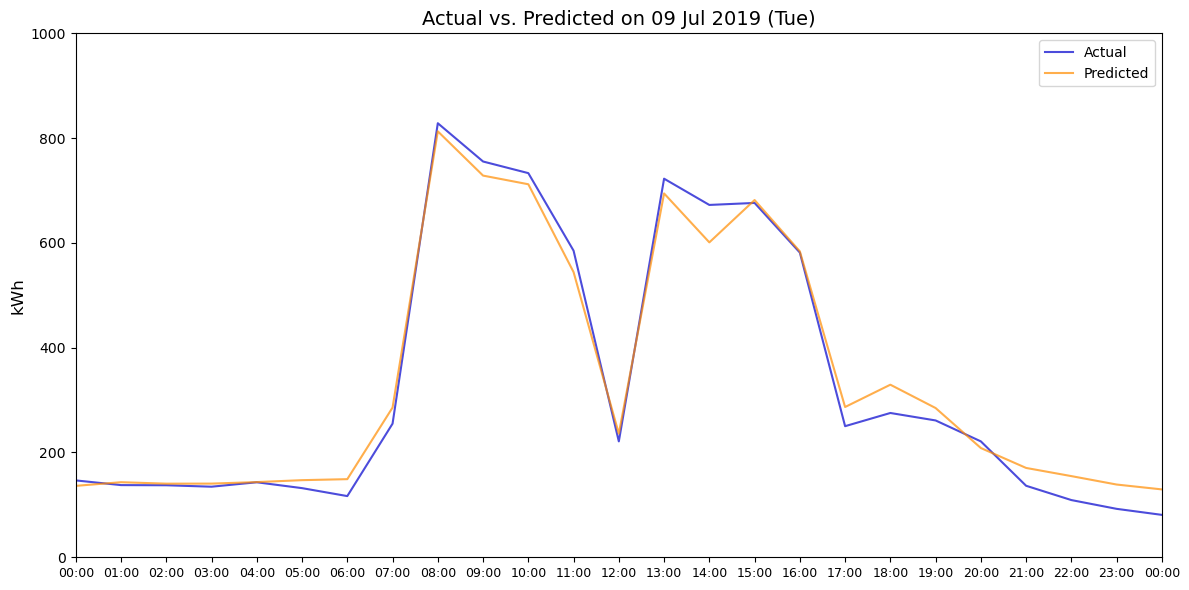

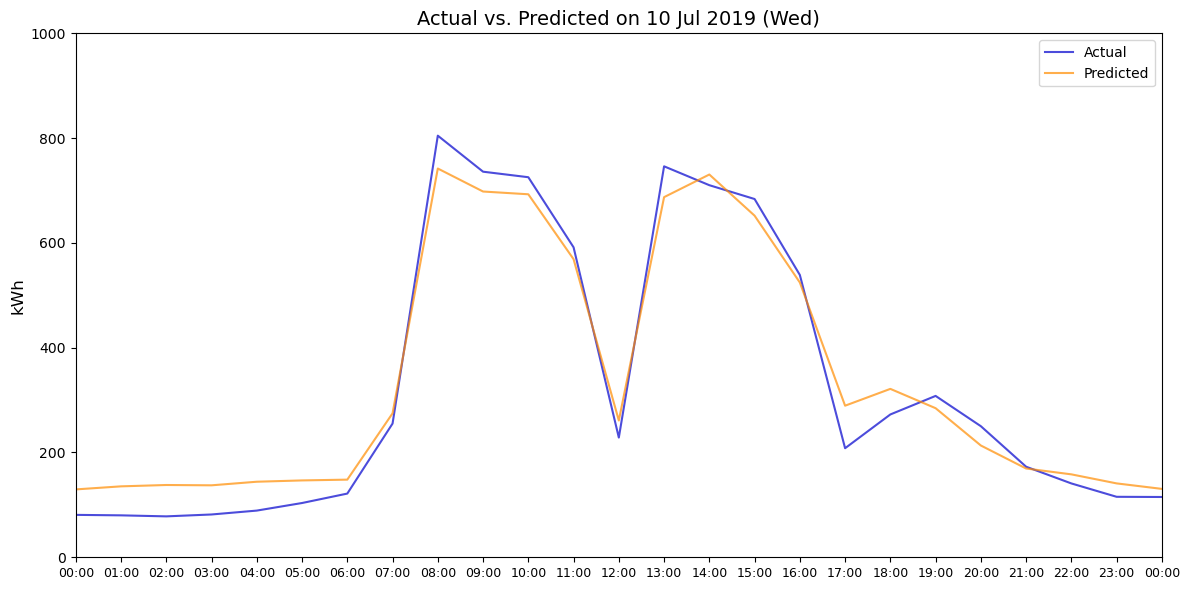

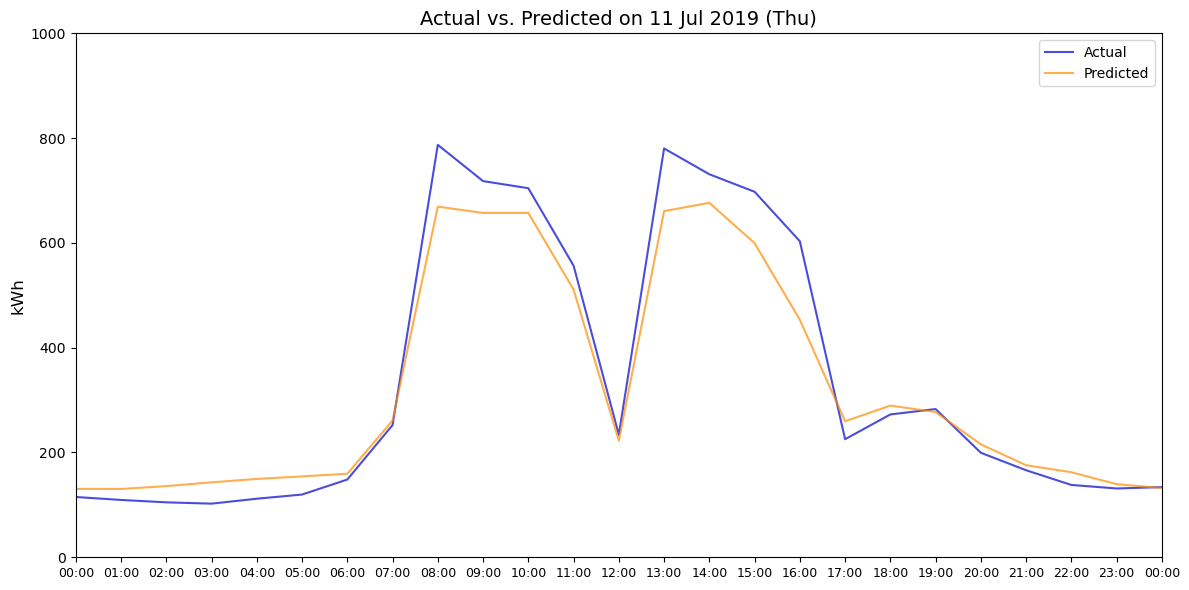

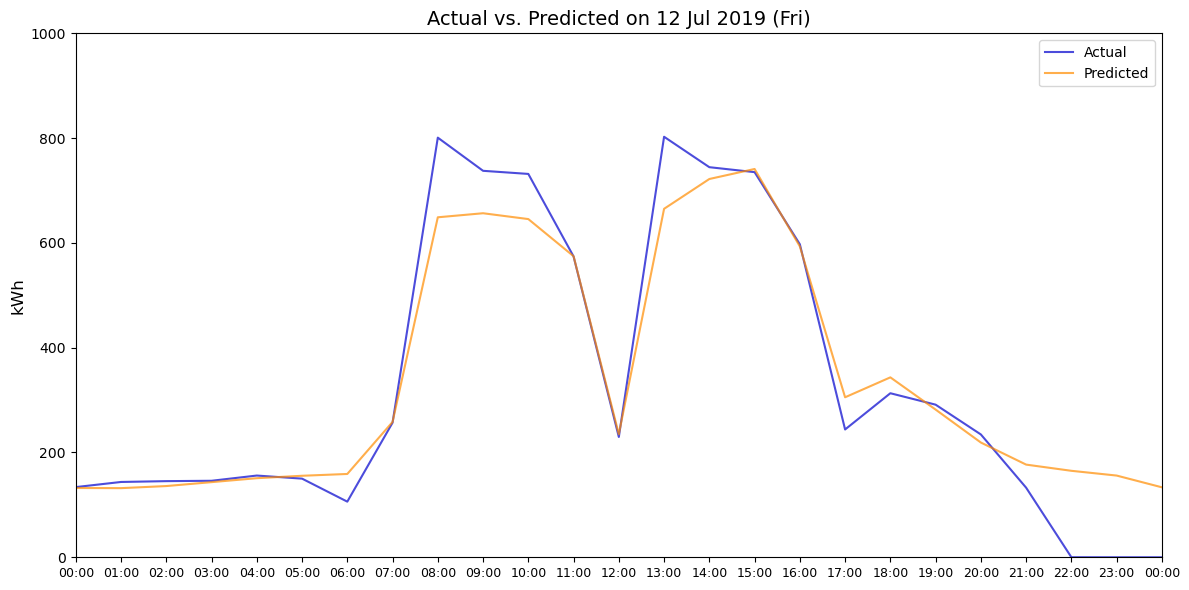

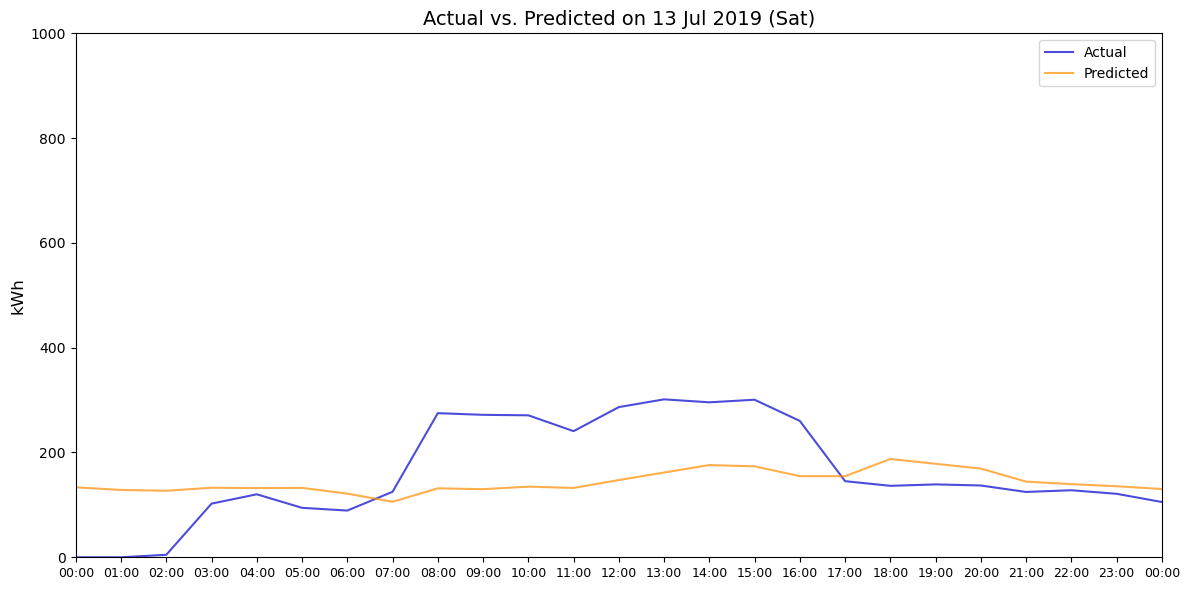

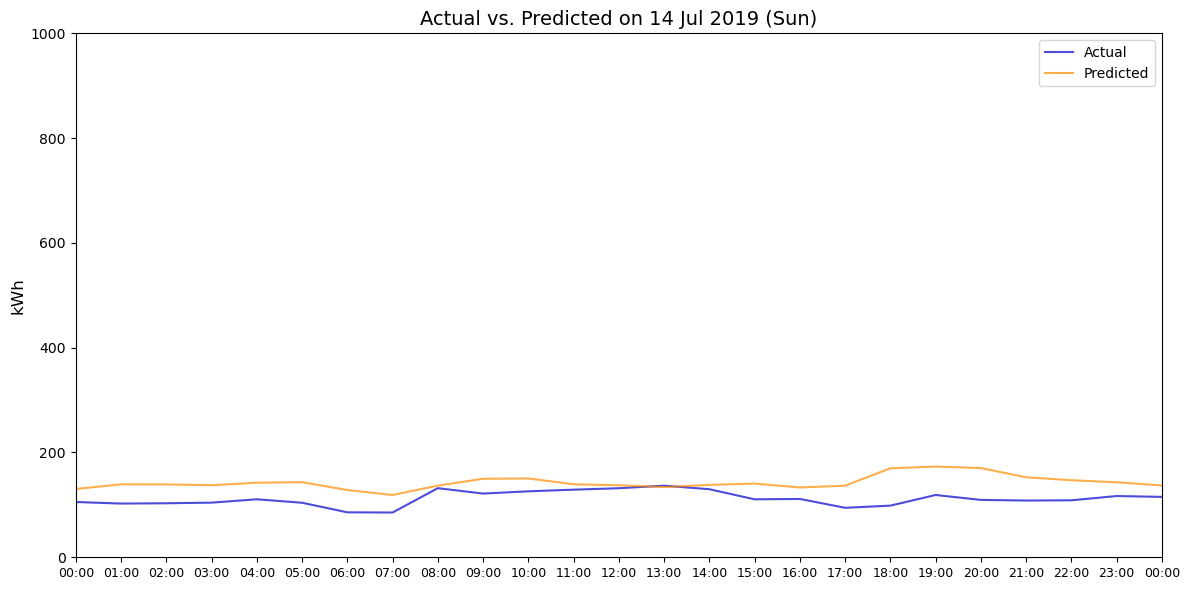

In [34]:
# Define the specific dates you want to plot
selected_days = ['2019-07-08', '2019-07-09', '2019-07-10', '2019-07-11', '2019-07-12', '2019-07-13', '2019-07-14']

# Convert to datetime for accurate filtering
selected_days = pd.to_datetime(selected_days)

# Loop through each selected day and plot
for day in selected_days:
    # Filter data for the current day and include 00:00 of the next day
    mask = (test_data['Date'] >= day) & (test_data['Date'] <= day + pd.Timedelta(days=1))
    filtered_data = test_data[mask]
    filtered_y_test = y_test[mask]
    filtered_y_pred = y_pred_test[mask]

    # Plotting Actual vs. Predicted for the current day
    plt.figure(figsize=(12, 6))
    plt.plot(filtered_data['Date'], filtered_y_test, label='Actual', linestyle='-', color='mediumblue', alpha=0.7)
    plt.plot(filtered_data['Date'], filtered_y_pred, label='Predicted', linestyle='-', color='darkorange', alpha=0.7)

    plt.xlabel('')
    plt.ylabel('kWh', fontsize=12)
    plt.ylim(0, 1000)
    #plt.title(f'Actual vs. Predicted on {day.strftime("%d-%b-%Y")}', fontsize=14)
    plt.title(f'Actual vs. Predicted on {day.strftime("%d %b %Y (%a)")}', fontsize=14)

    plt.legend()

    # Set x-axis ticks to every hour, extending to 00:00 of the next day
    hour_ticks = pd.date_range(start=day, end=day + pd.Timedelta(days=1), freq='h')
    plt.xticks(hour_ticks, hour_ticks.strftime('%H:%M'), fontsize=9)

    # Adjust x-axis limits to extend until 00:00 of the next day
    plt.xlim(day, day + pd.Timedelta(days=1))

    plt.tight_layout()
    plt.show()

In [35]:
# -------------------------------
# 6. Residual Plots
# -------------------------------

In [36]:
# Calculate residuals
residuals_train = y_train - y_pred_train
residuals_test = y_test - y_pred_test

# Determine Min-Max for common y-axis limits
residual_min = min(residuals_train.min(), residuals_test.min())
residual_max = max(residuals_train.max(), residuals_test.max())

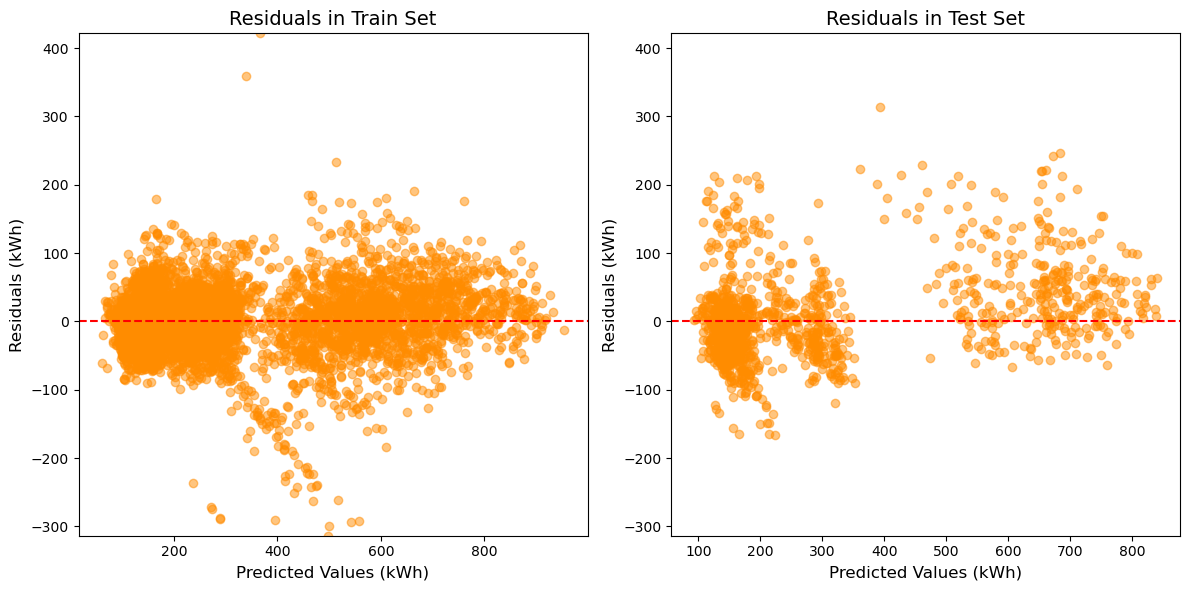

In [37]:
# Plot residuals
plt.figure(figsize=(12, 6))

# Train residuals
plt.subplot(1, 2, 1)
plt.scatter(y_pred_train, residuals_train, color='darkorange', alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.ylim(residual_min, residual_max)
plt.title('Residuals in Train Set', fontsize=14)
plt.xlabel('Predicted Values (kWh)', fontsize=12)
plt.ylabel('Residuals (kWh)', fontsize=12)

# Test residuals
plt.subplot(1, 2, 2)
plt.scatter(y_pred_test, residuals_test, color='darkorange', alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.ylim(residual_min, residual_max)
plt.title('Residuals in Test Set', fontsize=14)
plt.xlabel('Predicted Values (kWh)', fontsize=12)
plt.ylabel('Residuals (kWh)', fontsize=12)

plt.tight_layout()
plt.show()

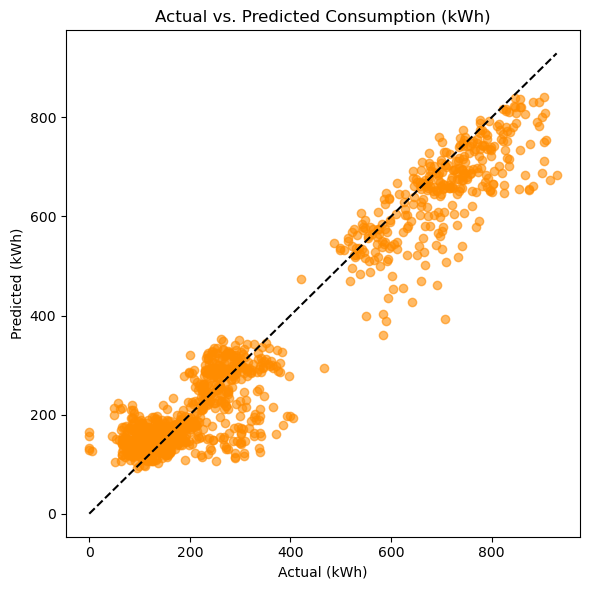

In [38]:
# Scatter plot of Actual vs. Predicted values
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_test, color='darkorange', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='black', linestyle='--')  # 45-degree line
plt.xlabel('Actual (kWh)')
plt.ylabel('Predicted (kWh)')
plt.title('Actual vs. Predicted Consumption (kWh)')
plt.tight_layout()
plt.show()

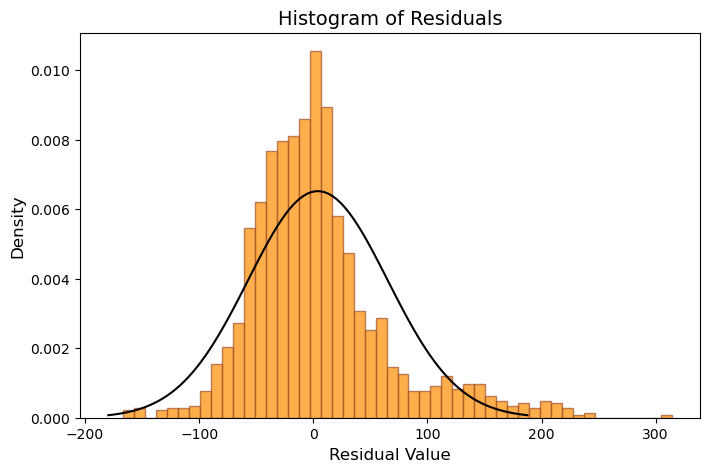

In [39]:
# Histogram of Residuals
plt.figure(figsize=(8, 5))
plt.hist(residuals_test, bins=50, density=True, alpha=0.7, color="darkorange", edgecolor="sienna")

# Calculate mean and standard deviation
mu, sigma = np.mean(residuals_test), np.std(residuals_test)

# Plot normal distribution curve
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma), color="black", linewidth=1.5)

# Add labels and title
plt.xlabel("Residual Value", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.title("Histogram of Residuals", fontsize=14)

# Display plot
plt.show()

In [40]:
# Residual statistics
residual_stats = {
    "Mean": np.mean(residuals_test),
    "Variance": np.var(residuals_test),
    "Skewness": stats.skew(residuals_test),     # skewness / asymmetry of the distribution
    "Kurtosis": stats.kurtosis(residuals_test)  # tailedness of the distribution
}
# Display residual statistics in a DataFrame
residual_df_summary = pd.DataFrame(residual_stats, index=["Residuals"])
print(residual_df_summary)

               Mean     Variance  Skewness  Kurtosis
Residuals  3.960186  3746.021064  1.156984  2.267327


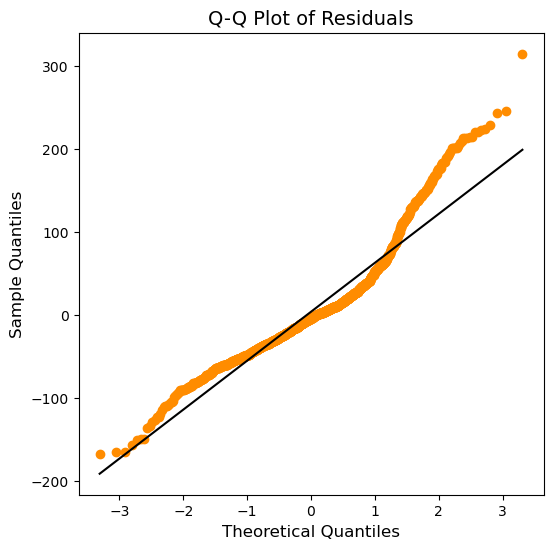

In [41]:
# Q-Q Plot for Normality Check
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)  # Add subplot to get axis object

# Generate Q-Q plot
stats.probplot(residuals_test, dist="norm", plot=ax)

# Customize colors
ax.get_lines()[0].set_color('darkorange')  # Data points
ax.get_lines()[1].set_color('black')       # 45-degree line

# Add titles and labels
ax.set_title("Q-Q Plot of Residuals", fontsize=14)
ax.set_xlabel("Theoretical Quantiles", fontsize=12)
ax.set_ylabel("Sample Quantiles", fontsize=12)

# Display plot
plt.show()


In [ ]:
####################### The End #######################